# Improving the Features

In [31]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from sklearn import metrics
%matplotlib inline
plt.style.use('ggplot')
%run scripts/performance_measures.py
sns.set_style('white')

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# stylesheet for notebook
HTML(open("styles/stylesheet.css", "r").read())

## Distribution of the Labelled Classes over the Coordinates

In [28]:
# read in the data
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip")

### Quasars

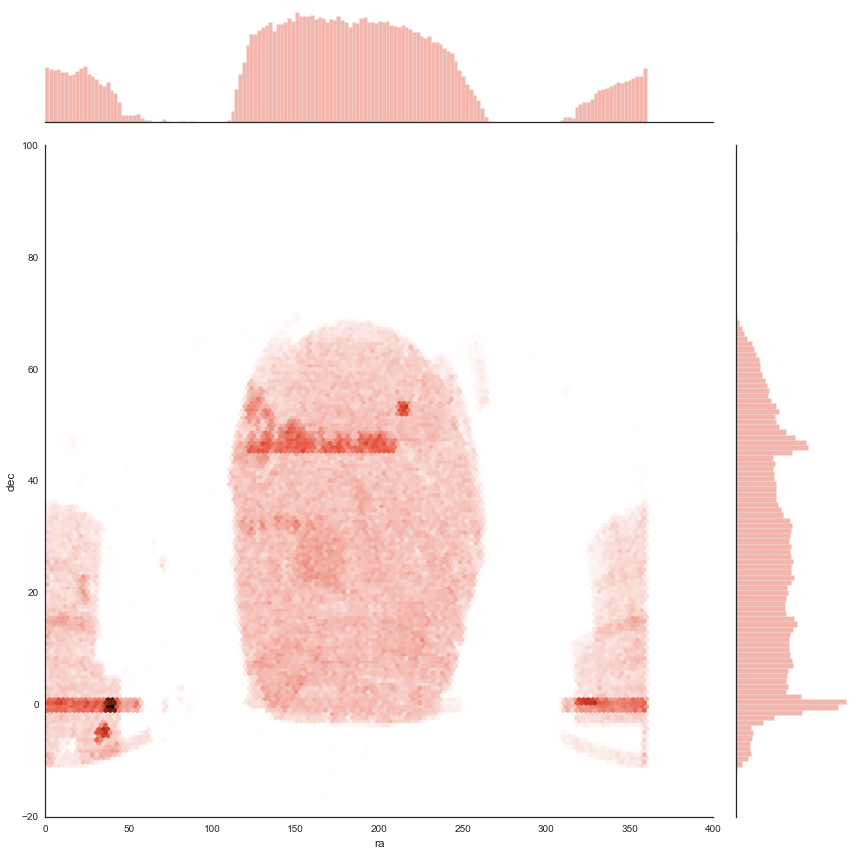

In [33]:
sns.jointplot(sdss[sdss['class']=='Quasar']['ra'], sdss[sdss['class']=='Quasar']['dec'], kind="hex", stat_func=None, size=12);

### Stars

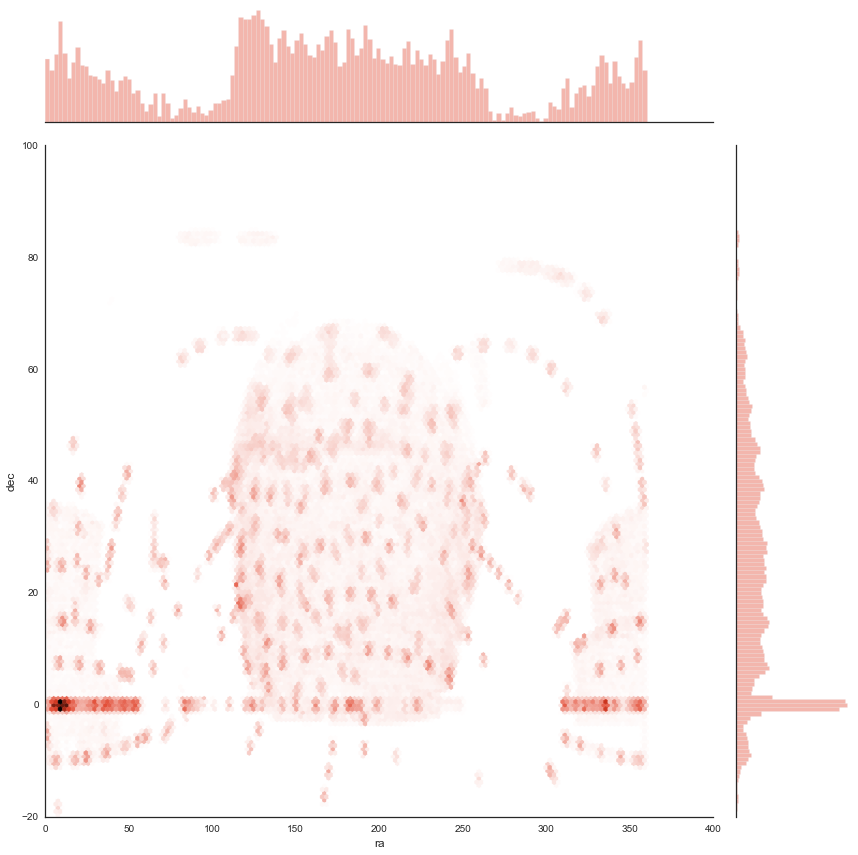

In [34]:
sns.jointplot(sdss[sdss['class']=='Star']['ra'], sdss[sdss['class']=='Star']['dec'], kind="hex", stat_func=None, size=12);

### Galaxies

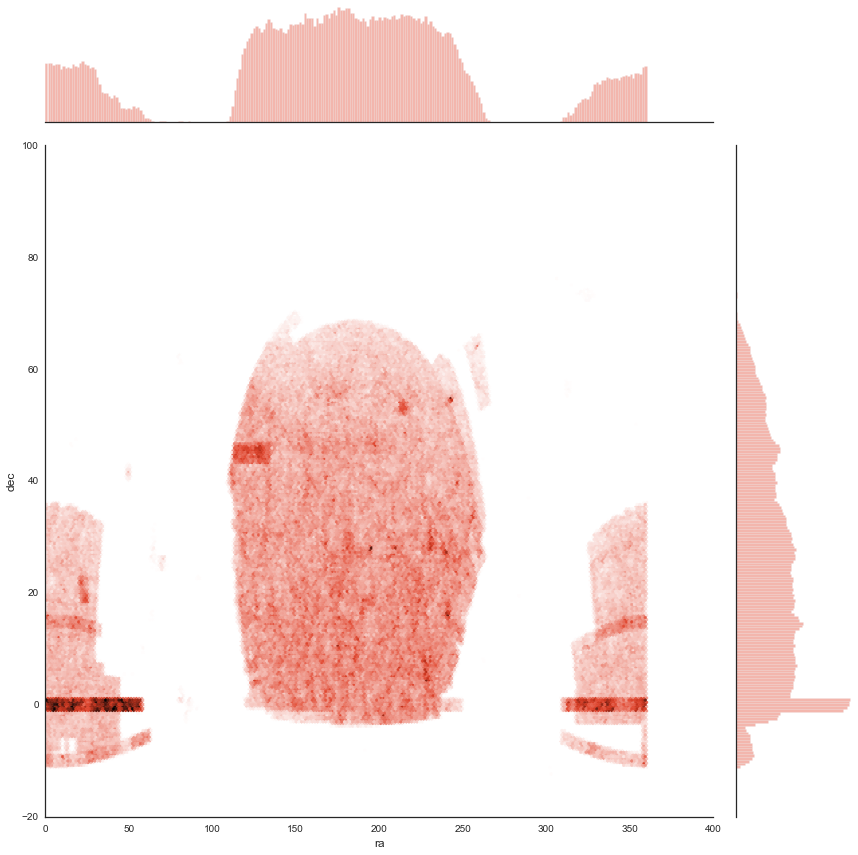

In [35]:
sns.jointplot(sdss[sdss['class']=='Galaxy']['ra'], sdss[sdss['class']=='Galaxy']['dec'], kind="hex", stat_func=None, size=12);

We can also just look at a small region in the sky. We can see that the distribution is quite uniform.

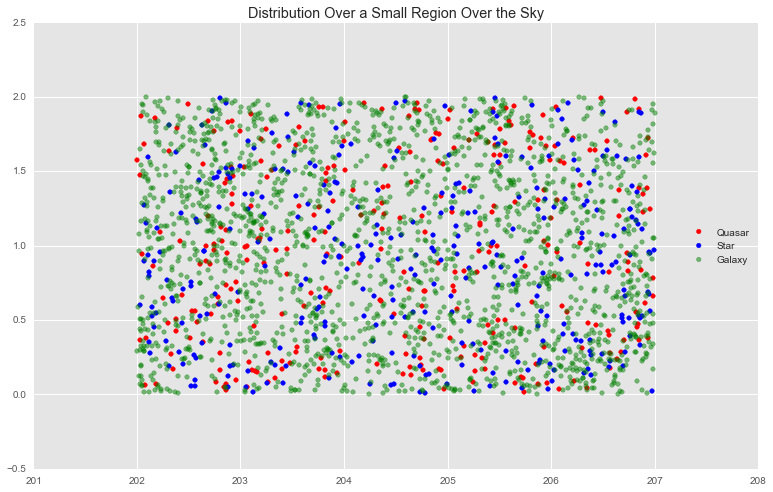

In [24]:
ra_small = np.logical_and(sdss['ra'] < 207, sdss['ra'] > 202)
dec_small = np.logical_and(sdss['dec'] > 0, sdss['dec'] < 2)
ra_dec_small = np.logical_and(ra_small, dec_small)
sdss = sdss[ra_dec_small]
fig, ax = plt.subplots(figsize=(13, 8))
ax.scatter(sdss[sdss['class']=='Quasar']['ra'], sdss[sdss['class']=='Quasar']['dec'], color='red', label='Quasar')
ax.scatter(sdss[sdss['class']=='Star']['ra'], sdss[sdss['class']=='Star']['dec'], color='blue', label='Star')
ax.scatter(sdss[sdss['class']=='Galaxy']['ra'], sdss[sdss['class']=='Galaxy']['dec'], color='green', alpha=0.5 , label='Galaxy')
ax.legend(loc='right')
ax.set_title('Distribution Over a Small Region Over the Sky')
plt.show()

## Coordinates as Features

Let's add coordinates as features.

In [84]:
# save the names of the 11 feature vectors and the target column
feature_names = ["ra", "dec", "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                 "petroMag_u", "petroMag_g", "petroMag_r", "petroMag_i", "petroMag_z", "petroRad_r"]
target_name = "class"

In [85]:
# split the data into a training set
X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss['class'], train_size=0.9, test_size=0.1)

Train Random Forest

In [86]:
clf_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight='auto', random_state=5)
clf_forest.fit(X_train, y_train)
y_pred_test = clf_forest.predict(X_test)
confusion_test = metrics.confusion_matrix(y_test, y_pred_test)
balanced_forest = balanced_accuracy_expected(confusion_test)

In [87]:
confusion_test

array([[168858,   1341,    594],
       [  1795,  33108,   3179],
       [  1362,   4070,  65794]])

In [88]:
balanced_forest

0.92733749689954892

A slight improvement, but not by much.

## Color Indices as Features

What if we use colour indices as features.

In [71]:
sdss['psf_u_g'] = sdss['psfMag_u'] - sdss['psfMag_g']
sdss['psf_g_r'] = sdss['psfMag_g'] - sdss['psfMag_r']
sdss['psf_r_i'] = sdss['psfMag_r'] - sdss['psfMag_i']
sdss['psf_i_z'] = sdss['psfMag_i'] - sdss['psfMag_z']
sdss['petro_u_g'] = sdss['petroMag_u'] - sdss['petroMag_g']
sdss['petro_g_r'] = sdss['petroMag_g'] - sdss['petroMag_r']
sdss['petro_r_i'] = sdss['petroMag_r'] - sdss['petroMag_i']
sdss['petro_i_z'] = sdss['petroMag_i'] - sdss['petroMag_z']
colour_features = ['psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z', 'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z', 'petroRadErr_r']

In [75]:
bX_train, X_test, y_train, y_test = train_test_split(sdss[colour_features], sdss['class'], train_size=0.9, test_size=0.1)
clf_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight='auto', random_state=5)
clf_forest.fit(X_train, y_train)
y_pred_test = clf_forest.predict(X_test)
confusion_test = metrics.confusion_matrix(y_test, y_pred_test)
balanced_forest = balanced_accuracy_expected(confusion_test)

In [76]:
confusion_test

array([[167615,   1622,   1216],
       [  2833,  32044,   3054],
       [  3316,   4180,  64221]])

In [77]:
balanced_forest

0.90780339798100429